In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


C:\Users\Malob\AppData\Local\Temp\ipykernel_7748\199254865.py:80: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.

C:\Users\Malob\AppData\Local\Temp\ipykernel_7748\199254865.py:90: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2002-01-01 00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Malob\AppData\Local\Temp\ipykernel_7748\199254865.py:157: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Malob\AppData\Local\Temp\ipykernel_7748\1992

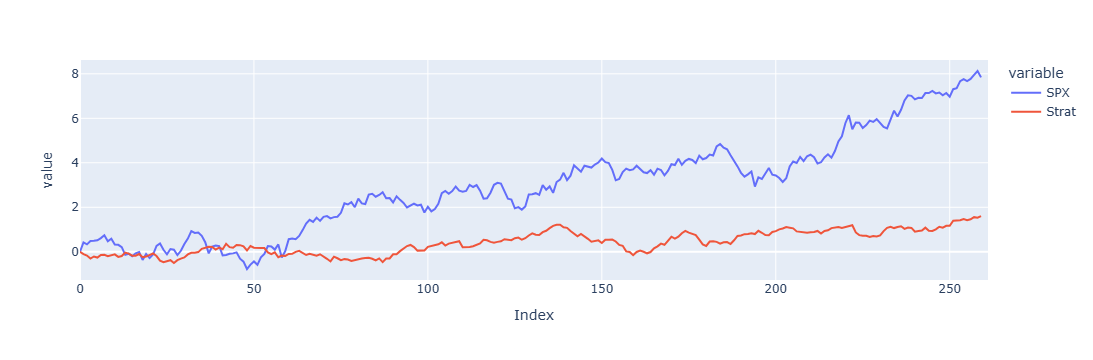

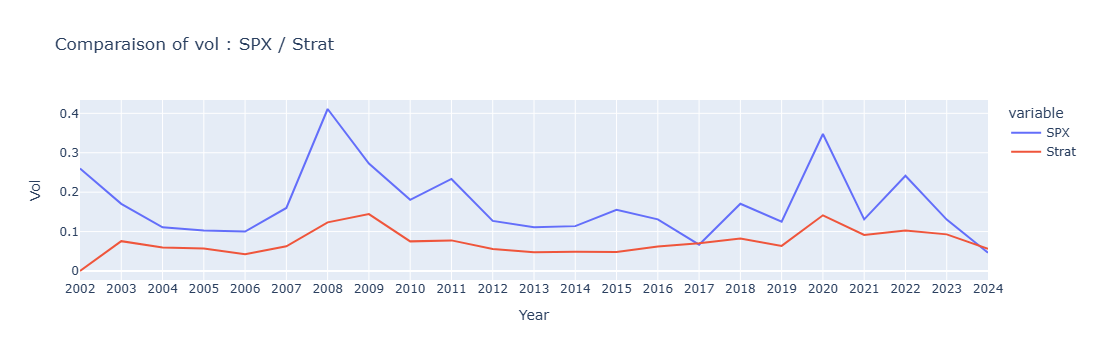

In [6]:


df = pd.read_csv("data.csv", sep=";", decimal=",")
df = df.rename(columns={
    "Column1": "Date",
    "Column2": "SPX",
    "Column3": "S5SFTW",
    "Column4": "S5PHRM",
    "Column5": "S5CPGS",
    "Column6": "S5ENRSX",
    "Column7": "S5FDBT",
    "Column8": "S5TECH",
    "Column9": "S5RETL",
    "Column10": "S5BANKX",
    "Column11": "S5HCES",
    "Column12": "S5DIVF",
    "Column13": "S5UTILX",
    "Column14": "S5MEDA",
    "Column15": "S5REAL",
    "Column16": "S5TELSX",
    "Column17": "S5MATRX",
    "Column18": "S5INSU",
    "Column19": "S5FDSR",
    "Column20": "S5HOUS",
    "Column21": "S5SSEQX",
    "Column22": "S5TRAN",
    "Column23": "S5HOTR",
    "Column24": "S5CODU",
    "Column25": "S5AUCO",
    "Column26": "S5COMS",
})
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["MonthIndex"] = df["Date"].dt.to_period("M")

#----------
#PARAMETERS
#----------
fees_rate=0.0002
# const
df_length = df.shape[1] - 2  # bcs of date and spx
last_rebalance = df.loc[0, "Date"]  # première date
month_count = 0

#Return a percentage between a and b
def evolution(v1, v2):
    return round((v2 - v1) / v1 * 100, 5)

#-------------------
#SORTER BETWEEN PERF
#-------------------

def DecilSorter(start, hist, proportion=3):
    bestperformer = []
    worstperformer = []
    performerc = []

    for i in range(2, df_length-1):
      performerc.append((evolution(float(df.iloc[start, i]), float(df.iloc[start + hist, i])), i))

    performerc.sort(reverse=True)
    offset=proportion
    for i in range(proportion):
        bestperformer.append(performerc[i][1])

    for i in range(len(performerc) - offset - proportion, len(performerc) - offset):
        worstperformer.append(performerc[i][1])


    return bestperformer, worstperformer


#--------------
#ALGO TITMANJEG
#--------------

def JeegadesshTitmanStrat(start=0, hold=6, hist=6, proportion=3):
    #new dataframe for stock quantity
    Indexcolumns = ["Date","SPX","S5SFTW","S5PHRM","S5CPGS","S5ENRSX","S5FDBT","S5TECH","S5RETL","S5BANKX","S5HCES","S5DIVF","S5UTILX","S5MEDA","S5REAL","S5TELSX","S5MATRX","S5INSU","S5FDSR","S5HOUS","S5SSEQX","S5TRAN","S5HOTR","S5CODU","S5AUCO","S5COMS","Money"]
    Tickercolumns=["S5SFTW","S5PHRM","S5CPGS","S5ENRSX","S5FDBT","S5TECH","S5RETL","S5BANKX","S5HCES","S5DIVF","S5UTILX","S5MEDA","S5REAL","S5TELSX","S5MATRX","S5INSU","S5FDSR","S5HOUS","S5SSEQX","S5TRAN","S5HOTR","S5CODU","S5AUCO","S5COMS"]
    StockQty = df.copy()
    StockQty.drop(columns="MonthIndex", inplace=True)
    StockQty.loc[:, :] = 0

    #starting data
    MoneyAtStart = 10000000
    month_count=0
    CurrentValue=MoneyAtStart

    #first ligne
    StockQty.loc[0, "Money"] = MoneyAtStart
    StockQty.loc[0, "SPX"] = df.iloc[0, 1]
    StockQty.loc[0, "Date"] = df.iloc[0, 0]

    #start of the algorithm

    for i in range(1,df.shape[0]):
      StockQty.iloc[i,0]=df.iloc[i,0]
      StockQty.iloc[i,1]=df.iloc[i,1]
      fees=0

      if df.loc[i, "Date"].month != df.loc[i-1, "Date"].month:
        month_count += 1


    # Si on atteint la période voulue
      if (i>= hist and month_count % hold == 0 and df.loc[i, "Date"].month != df.loc[i - 1, "Date"].month):
        #print(f"🔁 Rebalancement déclenché à la date : {df.loc[i, 'Date'].date()}")
        bestperformer, worstperformer = DecilSorter(i-hist, hist, proportion)


        for bestperf in bestperformer:
          StockQty.iloc[i,bestperf]=round((CurrentValue/(len(bestperformer)*2))/float(df.iloc[i,bestperf]),2)


        for worstperf in worstperformer:
          StockQty.iloc[i,worstperf]=round(-1*(CurrentValue/(len(worstperformer)*2))/float(df.iloc[i,worstperf]),2)

        for stocks in range(2,StockQty.shape[1]-1):
          if StockQty.iloc[i,stocks]!=StockQty.iloc[i-1,stocks]:
            fees+=abs(StockQty.iloc[i,stocks]-StockQty.iloc[i-1,stocks])*df.iloc[i,stocks]*fees_rate

      else :
        for stocks in range(2,StockQty.shape[1]-1):
          StockQty.iloc[i,stocks]=StockQty.iloc[i-1,stocks] #same qty
      #value of pf

      GainOrLoss = 0
      for stocks in range(2, StockQty.shape[1]-1):
          qty = StockQty.iloc[i, stocks]
          if qty != 0.0:
            price_now = df.iloc[i, stocks]
            price_prev = df.iloc[i - 1, stocks]
            GainOrLoss += qty * (price_now - price_prev)


      CurrentValue+=GainOrLoss-fees
      StockQty.iloc[i,-1]=CurrentValue

    return StockQty

results = JeegadesshTitmanStrat(0, 3, 9*22 , 3)


#---- GRAPH

"""
money_norm =(results["Money"]/10000000*100)-100
spx_norm=(results["SPX"]/results["SPX"].iloc[0]* 100)-100

fix = px.line(x=results["Date"], y=[money_norm, spx_norm],labels={"value":"Évolution en %", "variable":"Série"},title="Comparaison des évolutions en %")
fix.update_layout(hovermode="x unified")

fix.show()
"""

#-------- ANNUALISATION

AnnualizedDf=results[["Date","SPX","Money"]]
AnnualizedDf['Date'] = pd.to_datetime(AnnualizedDf['Date'])
AnnualizedDf['Year'] = AnnualizedDf['Date'].dt.year



YearList=AnnualizedDf["Year"].unique()
SPXAnnualized=pd.DataFrame(columns=YearList)
StratAnnualized=pd.DataFrame(columns=YearList)



for year in YearList:
  compteurPerYear=0
  for i in AnnualizedDf.index:
    if AnnualizedDf.loc[i,"Year"]==year:
      if compteurPerYear==0:
        SPXAnnualized.loc[compteurPerYear,year]=AnnualizedDf.loc[i,"SPX"]
        StratAnnualized.loc[compteurPerYear,year]=AnnualizedDf.loc[i,"Money"]
      else :
        SPXAnnualized.loc[compteurPerYear,year]=AnnualizedDf.loc[i,"SPX"]/SPXAnnualized.loc[0,year]*100-100
        StratAnnualized.loc[compteurPerYear,year]=AnnualizedDf.loc[i,"Money"]/StratAnnualized.loc[0,year]*100-100
      compteurPerYear+=1

for year in YearList:
  SPXAnnualized.loc[0,year]=SPXAnnualized.loc[0,year]/SPXAnnualized.loc[0,year]*100-100
  StratAnnualized.loc[0,year]=StratAnnualized.loc[0,year]/StratAnnualized.loc[0,year]*100-100



SPXAvg=[]
StratAvg=[]
for i in SPXAnnualized.index:
  sumSPX=0
  sumStrat=0
  for year in SPXAnnualized.columns:
    sumSPX+=SPXAnnualized.loc[i,year]
    sumStrat+=StratAnnualized.loc[i,year]
  SPXAvg.append(sumSPX/len(YearList))
  StratAvg.append(sumStrat/len(YearList))

#------- GRAPH / YEAR
"""
fig = px.line(SPXAnnualized, x=SPXAnnualized.index, y=SPXAnnualized.columns,labels={"value":"Returns in % of the SPX", "variable":"Years"},title="Comparaison of the returns on differents years | SPX")
fig.update_xaxes(tickmode='linear',  dtick=1,)
fig.show()


fig = px.line(StratAnnualized, x=StratAnnualized.index, y=StratAnnualized.columns,labels={"value":"Returns in % of the Start", "variable":"Years"},title="Comparaison of the returns on differents years | Strat")
fig.update_xaxes(tickmode='linear',  dtick=1,)
fig.show()
"""

SPXAnnualized=SPXAnnualized.drop(columns=2024) #too much nan
StratAnnualized=StratAnnualized.drop(columns=2024)

SPXAvg=[]
StratAVG=[]

for i in SPXAnnualized.index:
  sumSPX=0
  sumStrat=0
  for year in SPXAnnualized.columns:
    sumSPX+=SPXAnnualized.loc[i,year]
    sumStrat+=StratAnnualized.loc[i,year]
  SPXAvg.append(sumSPX/len(YearList))
  StratAVG.append(sumStrat/len(YearList))

dff = pd.DataFrame({"Index": (range(len(SPXAvg))),"SPX": SPXAvg,"Strat": StratAVG})


fig = px.line(dff, x="Index", y=["SPX","Strat"])
fig.show()


#---------- VOL


VolSPX = df[["Date", "SPX"]].copy()
VolSPX["Date"] = pd.to_datetime(VolSPX["Date"], dayfirst=True)
VolSPX["Year"] = VolSPX["Date"].dt.year
VolSPX["Return"] = np.log(VolSPX["SPX"] / VolSPX["SPX"].shift(1))
NumberofDayInYear=VolSPX.groupby("Year")["SPX"].count()
VolSPX = (VolSPX.groupby("Year")["Return"].std())
VolSPX = VolSPX * np.sqrt(NumberofDayInYear)


VolStrat=AnnualizedDf[["Money","Year"]].copy()
VolStrat["Money"]=VolStrat["Money"].astype(float)
VolStrat["Return"] = np.log(VolStrat["Money"] / VolStrat["Money"].shift(1))
NumberofDayInStrat=VolStrat.groupby("Year")["Money"].count()
VolStrat = (VolStrat.groupby("Year")["Return"].std())
VolStrat = VolStrat * np.sqrt(NumberofDayInStrat)

Vol=pd.concat([VolSPX,VolStrat],axis=1)
Vol.columns=["SPX","Strat"]


fig = px.line(Vol, x=Vol.index, y=Vol.columns,labels={"value":"Vol",},title="Comparaison of vol : SPX / Strat")
fig.update_xaxes(tickmode='linear',  dtick=1,)
fig.show()


In [ ]:
results

In [7]:
#the idea is the following

#create firstly the P matrix having wi,t= (-1/3 ; 0 ; 1/3) with i e [1,24] and t up to today, depending on the sign of the quantity in the result
c=0
PMatrix=np.zeros((0,24))
for lines in range(1,len(results)):
    positionList=[]
    print(results.iloc(lines,0))
    positionList.append(results.iloc(lines,0))
    for j in range(2,26):
        if results.iloc[lines-1,j]!=results.iloc[lines,j] and results.iloc[lines,j]!=0.0 :
            if results.iloc[lines,j]>0:
                positionList.append(1/3)
            else :
                positionList.append(-1/3)
        else :
            positionList.append(0)

    PMatrix=np.vstack((PMatrix,positionList))

PMatrix

TypeError: _LocationIndexer.__call__() takes from 1 to 2 positional arguments but 3 were given